### In this file, we consider the PDE system $\mathcal{L} \mathbf{u} = \mathbf{0}$ with Dirichlet boundary condition, where
$$
\mathcal{L}=\left[\begin{array}{cc}
1 & -\lambda \Delta \\
\lambda \Delta & 1
\end{array}\right],
\quad
\mathbf{u}=\left[\begin{array}{c} u_1 \\ u_2 \end{array}\right]
$$

In [52]:
import time
import os
import torch
import numpy as np
from torch import nn
from matplotlib import pyplot as plt

In [53]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu_info.name}")
    print(f"GPU memory: {gpu_info.total_memory / 1024**2:.2f} MB")

GPU: NVIDIA GeForce RTX 4090
GPU memory: 24217.31 MB


In [54]:
def generate_square_points(n, plot):
    # Boundary points per side without including corners
    boundary_spacing = np.linspace(1 / (2 * n), 1 - 1 / (2 * n), n)
    
    # Bottom boundary (x varies, y is 0)
    bottom_boundary = np.column_stack((boundary_spacing, np.zeros(n)))
    # Right boundary (x is 1, y varies)
    right_boundary = np.column_stack((np.ones(n), boundary_spacing))
    # Top boundary (x varies, y is 1)
    top_boundary = np.column_stack((boundary_spacing[::-1], np.ones(n)))
    # Left boundary (x is 0, y varies)
    left_boundary = np.column_stack((np.zeros(n), boundary_spacing[::-1]))
    
    # Combine boundary points in sequence
    boundary_points = np.vstack([bottom_boundary, right_boundary, top_boundary, left_boundary])

    t_boundary = np.zeros((len(boundary_points), 1)) 
    for i in range(len(boundary_points)):
        if(boundary_points[i,1] == 0):
            t_boundary[i] = boundary_points[i,0]
        elif(boundary_points[i,0] == 1):
            t_boundary[i] = 1 + boundary_points[i,1]
        elif(boundary_points[i,1] == 1):
            t_boundary[i] = 3 - boundary_points[i,0]
        else:
            t_boundary[i] = 4 - boundary_points[i,1]

    # Generate interior points if n > 2 (excluding boundary)
    if n > 2:
        x_interior = np.linspace(0.05, 0.95, n // 8)
        y_interior = np.linspace(0.05, 0.95, n // 8)
        xx_interior, yy_interior = np.meshgrid(x_interior, y_interior)
        interior_points = np.vstack([xx_interior.ravel(), yy_interior.ravel()]).T
    else:
        interior_points = np.empty((0, 2))  # No interior points if n <= 2

    # Plotting
    if plot:
        plt.figure(figsize=(6, 6))
        plt.scatter(interior_points[:, 0], interior_points[:, 1], color='blue', label='Interior Points', s=10)
        plt.scatter(boundary_points[:, 0], boundary_points[:, 1], color='red', label='Boundary Points', s=1)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title("Square Grid Points")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
    
    return 1 / n, t_boundary, boundary_points, interior_points

In [55]:
lambda_ = 0.05
N = 128

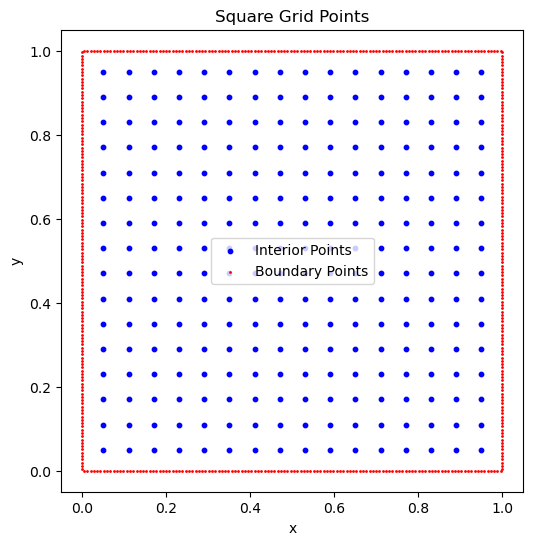

In [56]:
h, s_for_integral, x_bd, x_interior = generate_square_points(N, True)
s_for_intergal_pt = torch.from_numpy(s_for_integral).clone().float().to(device).view(-1, 1)
x_bd_pt = torch.from_numpy(x_bd).clone().float().to(device)
x_interior_pt = torch.from_numpy(x_interior).clone().float().to(device)

In [57]:
from scipy.special import keip, kerp, kei, ker

def kernel_1_1_bd(lambda_, t, s):   # lambda * G_i_j
    if s < 1:
        x1_s, x2_s, x1_prime_s, x2_prime_s = s, 0, 1, 0
    elif s < 2:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 1, s - 1, 0, 1
    elif s < 3:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 3 - s, 1, - 1, 0
    else:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 0, 4 - s, 0, -1
    
    if t < 1:
        x1_t, x2_t = t, 0
    elif t < 2:
        x1_t, x2_t = 1, t - 1
    elif t < 3:
        x1_t, x2_t = 3 - t, 1
    else:
        x1_t, x2_t = 0, 4 - t

    if (s != t):
        r = np.sqrt((x1_s - x1_t) ** 2 + (x2_s - x2_t) ** 2)
        result = - keip(r / np.sqrt(lambda_)) * (x2_prime_s * (x1_s - x1_t) - x1_prime_s * (x2_s - x2_t)) / (2 * np.pi * np.sqrt(lambda_) * r)
        return result
    else:
        return 0.
    
kernel_1_1_for_bd = torch.zeros(len(x_bd), len(x_bd))
for i in range(len(x_bd)):
    for j in range(len(x_bd)):
        kernel_1_1_for_bd[i, j] = h * kernel_1_1_bd(lambda_, s_for_integral[i, 0], s_for_integral[j, 0])

In [58]:
def kernel_1_2_bd(lambda_, t, s):   # lambda * G_i_j
    if s < 1:
        x1_s, x2_s, x1_prime_s, x2_prime_s = s, 0, 1, 0
    elif s < 2:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 1, s - 1, 0, 1
    elif s < 3:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 3 - s, 1, - 1, 0
    else:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 0, 4 - s, 0, -1
    
    if t < 1:
        x1_t, x2_t = t, 0
    elif t < 2:
        x1_t, x2_t = 1, t - 1
    elif t < 3:
        x1_t, x2_t = 3 - t, 1
    else:
        x1_t, x2_t = 0, 4 - t

    if (s != t):
        r = np.sqrt((x1_s - x1_t) ** 2 + (x2_s - x2_t) ** 2)
        result = - kerp(r / np.sqrt(lambda_)) * (x2_prime_s * (x1_s - x1_t) - x1_prime_s * (x2_s - x2_t)) / (2 * np.pi * np.sqrt(lambda_) * r)
        return result
    else:
        return 0.
    
kernel_1_2_for_bd = torch.zeros(len(x_bd), len(x_bd))
for i in range(len(x_bd)):
    for j in range(len(x_bd)):
        kernel_1_2_for_bd[i, j] = h * kernel_1_2_bd(lambda_, s_for_integral[i, 0], s_for_integral[j, 0])

In [59]:
def kernel_2_1_bd(lambda_, t, s):   # lambda * G_i_j
    return - kernel_1_2_bd(lambda_, t, s)
    
kernel_2_1_for_bd = torch.zeros(len(x_bd), len(x_bd))
for i in range(len(x_bd)):
    for j in range(len(x_bd)):
        kernel_2_1_for_bd[i, j] = h * kernel_2_1_bd(lambda_, s_for_integral[i, 0], s_for_integral[j, 0])

In [60]:
def kernel_2_2_bd(lambda_, t, s):   # lambda * G_i_j
    return kernel_1_1_bd(lambda_, t, s)
    
kernel_2_2_for_bd = torch.zeros(len(x_bd), len(x_bd))
for i in range(len(x_bd)):
    for j in range(len(x_bd)):
        kernel_2_2_for_bd[i, j] = h * kernel_2_2_bd(lambda_, s_for_integral[i, 0], s_for_integral[j, 0])

In [61]:
def predict_u_bd(net, lambda_, g):      
    # net: (batch_size, 2 * n_g) to (batch_size, 2 * n_g); lambda_: scalar; g: (batch_size, 2 * n_g)

    kernel_1_1 = kernel_1_1_for_bd.to(device)
    kernel_1_2 = - kernel_1_2_for_bd.to(device)
    kernel_2_1 = kernel_2_1_for_bd.to(device)
    kernel_2_2 = - kernel_2_2_for_bd.to(device)

    phi = net(g)
    phi1, phi2 = phi[:, 0: 4 * N], phi[:, 4 * N: 8 * N]
    k1 = (0.5 * phi1.T - kernel_1_1 @ phi2.T - kernel_1_2 @ phi1.T).T
    k2 = (0.5 * phi2.T - kernel_2_1 @ phi2.T - kernel_2_2 @ phi1.T).T

    return k1, k2, torch.cat((k1, k2), dim=1)

In [62]:
def kernel_1_1_int(lambda_, x, s):  # lambda * G_i_j
    x1, x2 = x[0], x[1]
    if s < 1:
        x1_s, x2_s, x1_prime_s, x2_prime_s = s, 0, 1, 0
    elif s < 2:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 1, s - 1, 0, 1
    elif s < 3:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 3 - s, 1, - 1, 0
    else:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 0, 4 - s, 0, -1
    r = np.sqrt((x1_s - x1) ** 2 + (x2_s - x2) ** 2)
    result = - keip(r / np.sqrt(lambda_)) * (x2_prime_s * (x1_s - x1) - x1_prime_s * (x2_s - x2)) / (2 * np.pi * np.sqrt(lambda_) * r)
    return result

kernel_1_1_for_int = torch.zeros(len(x_interior), len(x_bd))
for i in range(len(x_interior)):
    for j in range(len(x_bd)):
        kernel_1_1_for_int[i, j] = h * kernel_1_1_int(lambda_, x_interior[i, :], s_for_integral[j, 0])

In [63]:
def kernel_1_2_int(lambda_, x, s):  # lambda * G_i_j
    x1, x2 = x[0], x[1]
    if s < 1:
        x1_s, x2_s, x1_prime_s, x2_prime_s = s, 0, 1, 0
    elif s < 2:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 1, s - 1, 0, 1
    elif s < 3:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 3 - s, 1, - 1, 0
    else:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 0, 4 - s, 0, -1
    r = np.sqrt((x1_s - x1) ** 2 + (x2_s - x2) ** 2)
    result = - kerp(r / np.sqrt(lambda_)) * (x2_prime_s * (x1_s - x1) - x1_prime_s * (x2_s - x2)) / (2 * np.pi * np.sqrt(lambda_) * r)
    return result

kernel_1_2_for_int = torch.zeros(len(x_interior), len(x_bd))
for i in range(len(x_interior)):
    for j in range(len(x_bd)):
        kernel_1_2_for_int[i, j] = h * kernel_1_2_int(lambda_, x_interior[i, :], s_for_integral[j, 0])

In [64]:
def kernel_2_1_int(lambda_, x, s):  # lambda * G_i_j
    return - kernel_1_2_int(lambda_, x, s)

kernel_2_1_for_int = torch.zeros(len(x_interior), len(x_bd))
for i in range(len(x_interior)):
    for j in range(len(x_bd)):
        kernel_2_1_for_int[i, j] = h * kernel_2_1_int(lambda_, x_interior[i, :], s_for_integral[j, 0])

In [65]:
def kernel_2_2_int(lambda_, x, s):  # lambda * G_i_j
    return kernel_1_1_int(lambda_, x, s)

kernel_2_2_for_int = torch.zeros(len(x_interior), len(x_bd))
for i in range(len(x_interior)):
    for j in range(len(x_bd)):
        kernel_2_2_for_int[i, j] = h * kernel_2_2_int(lambda_, x_interior[i, :], s_for_integral[j, 0])

In [66]:
def predict_u_int(net, lambda_, g):      
    # net: (batch_size, 2 * n_g) to (batch_size, 2 * n_g); lambda_: scalar; g: (batch_size, 2 * n_g)

    kernel_1_1 = kernel_1_1_for_int.to(device)
    kernel_1_2 = - kernel_1_2_for_int.to(device)
    kernel_2_1 = kernel_2_1_for_int.to(device)
    kernel_2_2 = - kernel_2_2_for_int.to(device)

    phi = net(g)
    phi1, phi2 = phi[:, 0: 4 * N], phi[:, 4 * N: 8 * N]

    k1 = (-kernel_1_1 @ phi2.T - kernel_1_2 @ phi1.T).T
    k2 = (-kernel_2_1 @ phi2.T - kernel_2_2 @ phi1.T).T

    return k1, k2

In [67]:
g_np = np.random.rand(10000, 8 * N)

In [68]:
# np.linalg.matrix_rank(g_np, tol=1e-6)

In [69]:
class MLP(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_layers):
        super(MLP, self).__init__()
        self.act = nn.ReLU()
        self.layin = torch.nn.Linear(n_input, n_hidden)
        self.hidden_layers = torch.nn.ModuleList([torch.nn.Linear(n_hidden, n_hidden) for _ in range(n_layers)])
        self.layout = torch.nn.Linear(n_hidden, n_output)
    def forward(self, g):
       g = self.layin(g)
       g = self.act(g)
       for layer in self.hidden_layers:
           g = layer(g)
           g = self.act(g)
       h = self.layout(g)
       return h
    
class LinearBlock(nn.Module):
    def __init__(self, N):     
        super(LinearBlock, self).__init__()
        self.N = N
        self.G_layer = nn.Sequential(nn.Linear(self.N, self.N, bias = False))

    def forward(self, f):   
        return self.G_layer(f)

In [70]:
from torch.utils.data import TensorDataset, DataLoader, random_split

g_pt = torch.tensor(g_np, dtype=torch.float32).to(device)
dataset = TensorDataset(g_pt)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_g = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
test_g = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])

In [71]:
criterion = nn.MSELoss()
def compute_loss(net, g):
    _, _, predictions = predict_u_bd(net, lambda_, g)
    # print(predictions.shape, g.shape)
    loss = criterion(predictions, g)
    return loss

In [72]:
net = LinearBlock(8 * N).to(device)
parameters = net.parameters()

In [73]:
import time
import torch.optim.lr_scheduler as lr_scheduler

t0 = time.time()

train_loss_all = []
best_train_loss = 1.0
num_epochs = 50000
optimizer = torch.optim.Adam(parameters, lr = 1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 300, factor = 0.6, verbose=True)

patience = 500  
early_stopping_counter = 0

for epoch in range(num_epochs):
    
    net.train()
        
    optimizer.zero_grad()
    loss = compute_loss(net, train_g)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    net.eval()
    loss_test = compute_loss(net, test_g)

    if (epoch + 1) % 50 == 0:
        print("Epoch {}/{}".format(epoch + 1, num_epochs), "||  loss:", loss.item(), "||  loss_test:", loss_test.item())
        print("*" * 50)
    
    # Save the best model
    if loss_test.item() < best_train_loss:
        best_train_loss = loss_test.item()
        torch.save(net.state_dict(), "net.pth")
        early_stopping_counter = 0  # Reset counter
    else:
        early_stopping_counter += 1

    # Early stopping check
    if early_stopping_counter >= patience:
        print(f"Early stopping triggered! Best validation loss: {best_train_loss:.6f}, achieved at epoch {epoch + 1 - patience}.")
        break

T = time.time() - t0
print("Total training time: {:.2f} seconds".format(T))

Epoch 50/50000 ||  loss: 0.08743780851364136 ||  loss_test: 0.08785591274499893
**************************************************
Epoch 100/50000 ||  loss: 0.0825745165348053 ||  loss_test: 0.08379346132278442
**************************************************
Epoch 150/50000 ||  loss: 0.07780616730451584 ||  loss_test: 0.07992441952228546
**************************************************
Epoch 200/50000 ||  loss: 0.07304710894823074 ||  loss_test: 0.0760936588048935
**************************************************
Epoch 250/50000 ||  loss: 0.06844376027584076 ||  loss_test: 0.07239096611738205
**************************************************
Epoch 300/50000 ||  loss: 0.06407445669174194 ||  loss_test: 0.06885883957147598
**************************************************
Epoch 350/50000 ||  loss: 0.05997620150446892 ||  loss_test: 0.0655129998922348
**************************************************
Epoch 400/50000 ||  loss: 0.056160181760787964 ||  loss_test: 0.06235346570611
*

In [74]:
net.load_state_dict(torch.load("net.pth", map_location = device))

<All keys matched successfully>

In [75]:
def compute_errors(predicted_u, exact_u):
    error_inf_abs = torch.max(torch.abs(predicted_u - exact_u))
    error_2_abs = torch.norm(predicted_u - exact_u, p=2) / torch.sqrt(torch.tensor(exact_u.numel(), dtype=torch.float))

    error_inf_rel = error_inf_abs / torch.max(torch.abs(exact_u))
    error_2_rel = torch.norm(predicted_u - exact_u, p=2) / torch.norm(exact_u, p=2)

    print("L_inf absolute error:", error_inf_abs.item(), "|| L_2 absolute error:", error_2_abs.item())
    print("L_inf relative error:", error_inf_rel.item(), "|| L_2 relative error:", error_2_rel.item()) 

def plot(u_int_pre, u_int_exact, u_bd_pre, u_bd_exact):
    x_all = np.concatenate([x_interior, x_bd], axis=0)
    # print(x_all.shape)

    u_exact = np.concatenate([u_int_exact.cpu().detach().numpy(), u_bd_exact.cpu().detach().numpy()], axis=1).T
    # print(u_exact.shape)

    u_pre = np.concatenate([u_int_pre.cpu().detach().numpy(), u_bd_pre.cpu().detach().numpy()], axis = 1).T
    # print(u_pre.shape)
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)
    
    sc = axs[0].scatter(x_all[:, 0], x_all[:, 1], c=u_exact, cmap='viridis', marker='o', s=20)
    axs[0].set_xlabel("X coordinate")
    axs[0].set_ylabel("Y coordinate")
    axs[0].set_title(f"Exact solution")
    axs[0].set_aspect('equal')
    fig.colorbar(sc, ax=axs[0], orientation='vertical', label="U values")

    sc = axs[1].scatter(x_all[:, 0], x_all[:, 1], c=u_pre, cmap='viridis', marker='o', s=20)
    axs[1].set_xlabel("X coordinate")
    axs[1].set_ylabel("Y coordinate")
    axs[1].set_title(f"Numerical solution")
    axs[1].set_aspect('equal')
    fig.colorbar(sc, ax=axs[1], orientation='vertical', label="U values")

    sc = axs[2].scatter(x_all[:, 0], x_all[:, 1], c=u_exact - u_pre, cmap='viridis', marker='o', s=20)
    axs[2].set_xlabel("X coordinate")
    axs[2].set_ylabel("Y coordinate")
    axs[2].set_title(f"Error")
    axs[2].set_aspect('equal')
    fig.colorbar(sc, ax=axs[2], orientation='vertical', label="Error values")

    plt.show()

    compute_errors(torch.from_numpy(u_pre), torch.from_numpy(u_exact)) 

In [76]:
a = 1.2

def U1(lambda_, x):
    x_np = x.cpu().detach().numpy()
    x1 = x_np[:, 0].reshape((-1, 1))
    x2 = x_np[:, 1].reshape((-1, 1))
    r = np.sqrt((x1 - a) * (x1 - a) + (x2 - a) * (x2 - a))
    ans_np = - kei(r / np.sqrt(lambda_)) / (2 * np.pi * lambda_) 
    return torch.from_numpy(ans_np).clone().float().to(device)

def U2(lambda_, x):
    x_np = x.cpu().detach().numpy()
    x1 = x_np[:, 0].reshape((-1, 1))
    x2 = x_np[:, 1].reshape((-1, 1))
    r = np.sqrt((x1 - a) * (x1 - a) + (x2 - a) * (x2 - a))
    ans_np = ker(r / np.sqrt(lambda_)) / (2 * np.pi * lambda_) 
    return torch.from_numpy(ans_np).clone().float().to(device)

def validation(net):
    g1 = U1(lambda_, x_bd_pt).view(1, -1)
    g2 = U2(lambda_, x_bd_pt).view(1, -1)
    g = torch.cat((g1, g2), dim = 1)    # (1, 8 * N)
    
    u1_int_pre, u2_int_pre = predict_u_int(net, lambda_, g)
    u1_int_exact, u2_int_exact = U1(lambda_, x_interior_pt).view(1, -1), U2(lambda_, x_interior_pt).view(1, -1)
    u1_bd_pre, u2_bd_pre, _ = predict_u_bd(net, lambda_, g)
    u1_bd_exact, u2_bd_exact = U1(lambda_, x_bd_pt).view(1, -1), U2(lambda_, x_bd_pt).view(1, -1)

    return u1_int_pre, u2_int_pre, u1_int_exact, u2_int_exact, u1_bd_pre, u2_bd_pre, u1_bd_exact, u2_bd_exact

In [77]:
u1_int_pre, u2_int_pre, u1_int_exact, u2_int_exact, u1_bd_pre, u2_bd_pre, u1_bd_exact, u2_bd_exact = validation(net)

In the domain: 
L_inf absolute error: 0.000552058219909668 || L_2 absolute error: 3.877816561725922e-05
L_inf relative error: 0.000563299108762294 || L_2 relative error: 0.00023700721794739366
On the boundary:
L_inf absolute error: 2.6226043701171875e-06 || L_2 absolute error: 2.053758691999974e-07
L_inf relative error: 2.05649030249333e-06 || L_2 relative error: 6.052721346350154e-07


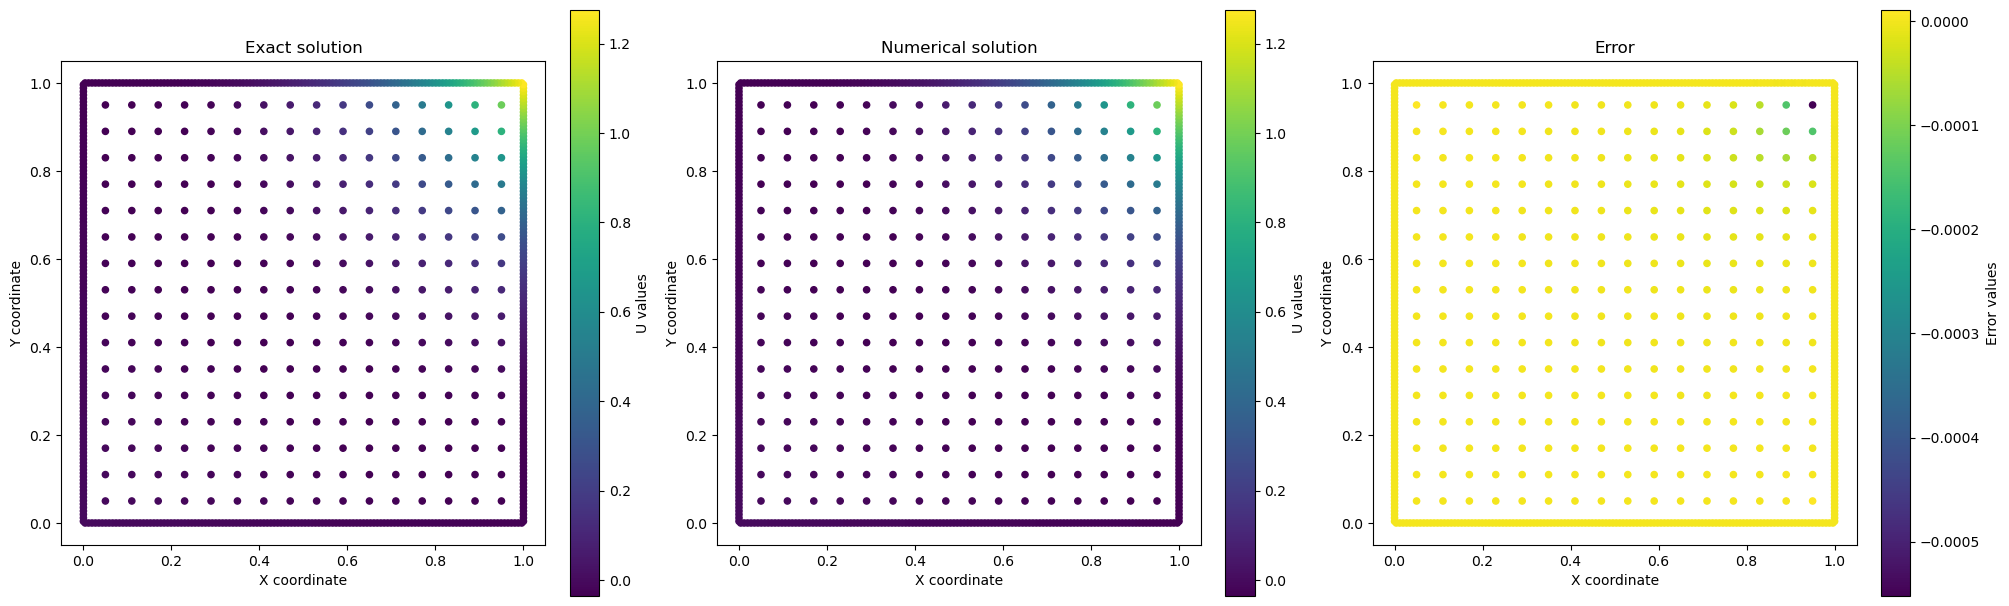

L_inf absolute error: 0.000552058219909668 || L_2 absolute error: 2.2389211153495125e-05
L_inf relative error: 0.00043289121822454035 || L_2 relative error: 7.648976315977052e-05


In [78]:
print("In the domain: ")
compute_errors(u1_int_pre, u1_int_exact)

print("On the boundary:")
compute_errors(u1_bd_pre, u1_bd_exact)

plot(u1_int_pre, u1_int_exact, u1_bd_pre, u1_bd_exact)

In the domain: 
L_inf absolute error: 0.00017484277486801147 || L_2 absolute error: 1.1768579497584142e-05
L_inf relative error: 0.0007739889551885426 || L_2 relative error: 0.00010938572813756764
On the boundary:
L_inf absolute error: 9.592622518539429e-07 || L_2 absolute error: 1.1932009158499568e-07
L_inf relative error: 2.264130216644844e-06 || L_2 relative error: 1.0478098602106911e-06


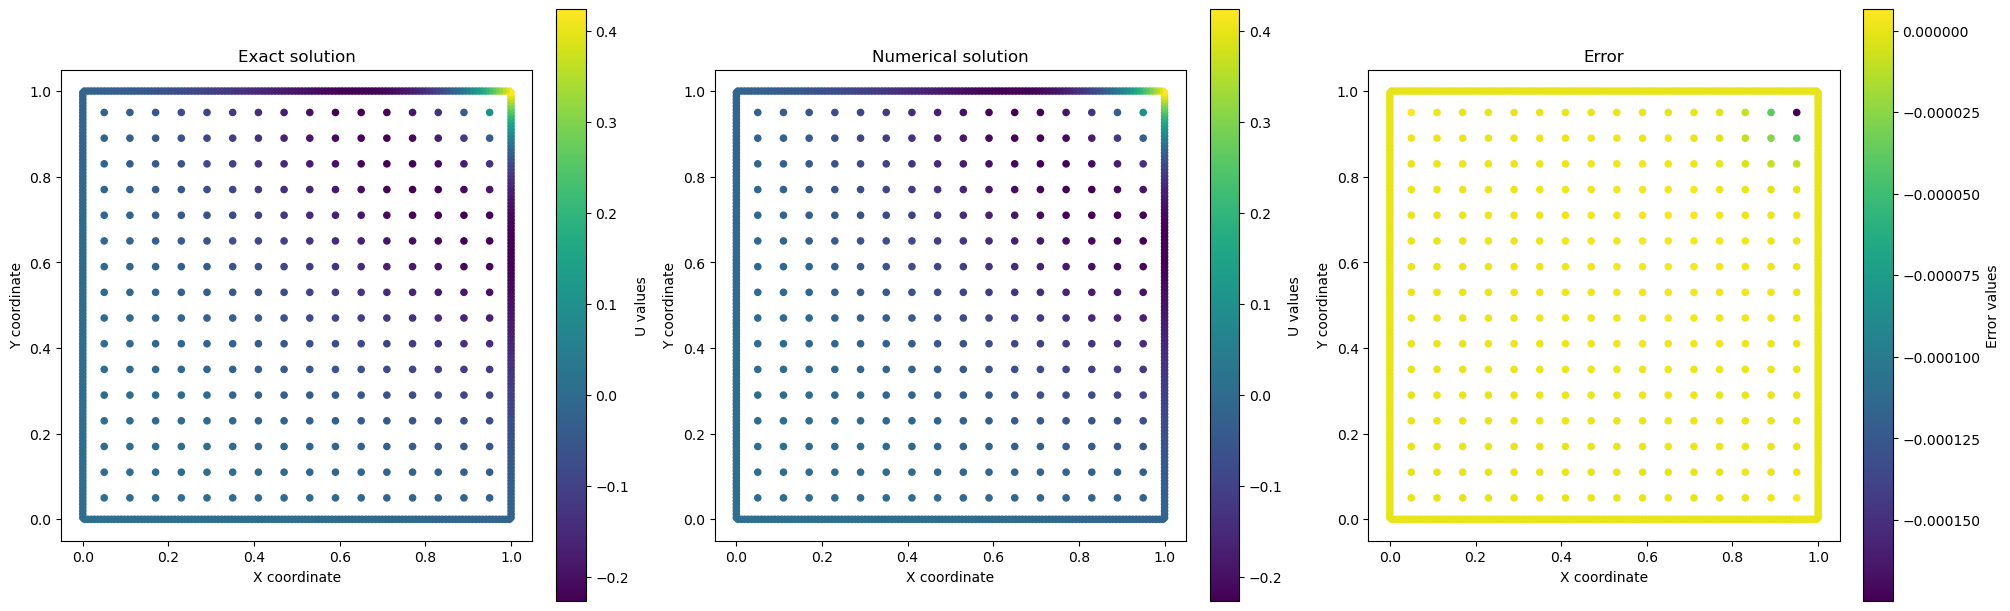

L_inf absolute error: 0.00017484277486801147 || L_2 absolute error: 6.795290119043784e-06
L_inf relative error: 0.0004126784042455256 || L_2 relative error: 6.077041325625032e-05


In [79]:
print("In the domain: ")
compute_errors(u2_int_pre, u2_int_exact)

print("On the boundary:")
compute_errors(u2_bd_pre, u2_bd_exact)

plot(u2_int_pre, u2_int_exact, u2_bd_pre, u2_bd_exact)